In [ ]:
from datasets import load_dataset

dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [ ]:
def filterDomains(data):
    
    return [entry for entry in data if set(entry["services"]).issubset({"restaurant", "hotel", "booking"}) and len(entry["services"]) == 1]
# Only keep dialogues related to Restaurants or Hotels.

train_data_filtered = filterDomains(train_data)
val_data_filtered = filterDomains(val_data)
test_data_filtered = filterDomains(test_data)

In [ ]:
def add_data_to_be_retrieved(dataset, print_dialogue=False):
    """
    Augment the dataset with the following information:
    - Information to be retrieved (ground truth)
    
    Heavily inspired by the code from the evaluation script.
    """
    
    for dialogue in dataset:
        turns = dialogue["turns"]
        turns["to_be_retrieved_ground_truth"] = {turn_id: [] for turn_id in range(len(turns["turn_id"]))}
        
        
        for turn_id, _ in enumerate(turns["turn_id"]):
            # If it is SYSTEM turn:
            if turns["speaker"][turn_id]:
                slot_names_per_act = [slot['slot_name'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                slot_values_per_act = [slot['slot_value'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                dialogue_acts = turns['dialogue_acts'][turn_id]['dialog_act']['act_type']
                services = turns['frames'][turn_id]['service']
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]

                to_be_retrieved_ground_truth = []
                for act_i in range(len(slot_names_per_act)):
                    domain = dialogue_acts[act_i].split("-")[0].lower()
                    if domain == "booking" and len(current_booking_service) ==1:
                        domain = current_booking_service[0]
                    slot_names = [domain+"-"+slot_names_per_act[act_i][slot_i] for slot_i in range(len(slot_names_per_act[act_i]))
                                    if slot_values_per_act[act_i][slot_i]!="?" and slot_names_per_act[act_i][slot_i]!="none"]
                    if slot_names:
                        to_be_retrieved_slot_names = ["%s-availability" % (domain)] + slot_names
                        while domain+"-choice" in to_be_retrieved_slot_names:
                            del to_be_retrieved_slot_names[to_be_retrieved_slot_names.index(domain+"-choice")]
                        to_be_retrieved_ground_truth.extend(to_be_retrieved_slot_names)
                to_be_retrieved_ground_truth = sorted(list(set(to_be_retrieved_ground_truth)))
                
                # augment the dataset
                turns["to_be_retrieved_ground_truth"][turn_id].extend(to_be_retrieved_ground_truth)
                
                if print_dialogue:
                    print(f"Utterance: {turns['utterance'][turn_id]}")
                    print(f"To be retrieved: {to_be_retrieved_ground_truth}")
        if print_dialogue:        
            print("-"*50)
                       

In [ ]:
def add_data_to_be_provided(dataset):
    """
    Augment the dataset with the following information:
    - Information to be provided (ground truth)
    
    Heavily inspired by the code from the evaluation script.
    """
    for dialogue in dataset:
        turns = dialogue["turns"]
        turns["to_be_provided_overall"] = {turn_id: [] for turn_id in range(len(turns["turn_id"]))}
        
        
        for turn_id, _ in enumerate(turns["turn_id"]):
            # If it is SYSTEM turn:
            if turns["speaker"][turn_id]:
                slot_names_per_act = [slot['slot_name'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                slot_values_per_act = [slot['slot_value'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                dialogue_acts = turns['dialogue_acts'][turn_id]['dialog_act']['act_type']
                services = turns['frames'][turn_id]['service']
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                to_be_provided_overall = []
                
                for act_i in range(len(slot_names_per_act)):
                    domain = dialogue_acts[act_i].split("-")[0].lower()
                    if domain == "booking" and len(current_booking_service)==1:
                        domain = current_booking_service[0]
                    if domain in ["hotel", "restaurant", "booking", "general"]:
                        slot_names_vlues = [domain+"-"+slot_names_per_act[act_i][slot_i]+":"+slot_values_per_act[act_i][slot_i] for slot_i in range(len(slot_names_per_act[act_i]))
                                            if slot_values_per_act[act_i][slot_i]!="?" and slot_names_per_act[act_i][slot_i]!="none"]
                        if slot_names_vlues and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in slot_names_vlues)) and not "-No" in dialogue_acts[act_i]:
                            to_be_provided = ["%s-availability:yes" % (domain)] + slot_names_vlues
                            to_be_provided_overall.extend(to_be_provided)
                        elif "-No" in dialogue_acts[act_i]:
                            to_be_provided = ["%s-availability:no" % (domain)] + slot_names_vlues
                            to_be_provided_overall.extend(to_be_provided)
                to_be_provided_overall = sorted(list(set(to_be_provided_overall)))
                remove_avail_no_list = [elem for elem in to_be_provided_overall if elem.endswith("availability:no")]
                for remove_avail in remove_avail_no_list:
                    remove_avail_yes = remove_avail[:-2]+"yes"
                    while remove_avail_yes in to_be_provided_overall:
                        del to_be_provided_overall[to_be_provided_overall.index(remove_avail_yes)]
                turns["to_be_provided_overall"][turn_id].extend(to_be_provided_overall)

In [154]:
add_data_to_be_provided(train_data_filtered)
add_data_to_be_retrieved(train_data_filtered)

add_data_to_be_provided(val_data_filtered)
add_data_to_be_retrieved(val_data_filtered)

add_data_to_be_provided(test_data_filtered)
add_data_to_be_retrieved(test_data_filtered)

In [155]:

for turn_id in range(10):
    print(train_data_filtered[turn_id]["turns"]["utterance"][1])
    print("To be provided: ")
    print(train_data_filtered[turn_id]["turns"]["to_be_provided_overall"][1])
    print("To be retrieved: ")
    print(train_data_filtered[turn_id]["turns"]["to_be_retrieved_ground_truth"][1])
    print("-"*50)

I have 4 different options for you. I have two cheaper guesthouses and two expensive hotels. Do you have a preference?
To be provided: 
['hotel-availability:yes', 'hotel-choice:4', 'hotel-pricerange:cheaper', 'hotel-pricerange:expensive', 'hotel-type:guesthouses', 'hotel-type:hotels']
To be retrieved: 
['hotel-availability', 'hotel-pricerange', 'hotel-type']
--------------------------------------------------
I've heard good things about the lucky star. Need a reservation?
To be provided: 
['restaurant-availability:yes', 'restaurant-name:the lucky star']
To be retrieved: 
['restaurant-availability', 'restaurant-name']
--------------------------------------------------
Eraina is a European restaurant in the centre area. Their address is St. Michael's Church Trinity Street City Centre and phone number 01223 355166.
To be provided: 
["restaurant-address:St. Michael's Church Trinity Street City Centre", 'restaurant-area:centre', 'restaurant-availability:yes', 'restaurant-food:European', 're

# 1. Predict what shall be retrieved

#### Idea: Predict what the agent should retrieve based on the user utterance, dialogue act and the previous agent utterance.
    

# 2. Predict dialogue acts of the agent

#### We can and should use the results of the retrieval, i.e. use slots which we requested at the first step and their values (including "yes/no" for the availability slot)

# 3. Predict what information shall be requested

#### Once again using the results of the retrieval and likely the user's utterance and dialogue act

In [128]:
def extract_relevant_data(dataset):
    """
    Create a dataset that can be used for using the what shall be requested model.
    """
    
    user_dialogue_acts = []
    extracted_information = []
    retrieved_information = []
    information_to_be_requested = []
    
    for dialogue in dataset:
        turns = dialogue["turns"]
        
        for turn_id, _ in enumerate(turns["turn_id"]):
            
            # if it is the USER turn:
            if not turns["speaker"][turn_id]:
                
                # flatten the dialogue acts
                utterance = turns['utterance'][turn_id]
                user_dialogue_acts.append(turns['dialogue_acts'][turn_id]['dialog_act']['act_type'])
                slot_names_per_act = [slot['slot_name'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                slot_values_per_act = [slot['slot_value'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                current_slots = []
                for  slot_name, slot_value in zip(slot_names_per_act, slot_values_per_act):
                    if slot_name[0] != "none":
                        current_slots.append(slot_name[0]+":"+slot_value[0])
                extracted_information.append(current_slots)
                
            
            # If it is SYSTEM turn:
            if turns["speaker"][turn_id]:
                
                utterance = turns['utterance'][turn_id]
                retrieved_information.append(turns['to_be_provided_overall'][turn_id])
                # get the slot names with '?' as value
                slot_names_per_act = [slot['slot_name'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                slot_values_per_act = [slot['slot_value'] for slot in turns['dialogue_acts'][turn_id]['dialog_act']['act_slots']]
                slots_to_be_requested = []
                for act_i in range(len(slot_names_per_act)):
                    for slot_name, slot_value in zip(slot_names_per_act[act_i], slot_values_per_act[act_i]):
                        if slot_value == "?":
                            slots_to_be_requested.append(slot_name)
                information_to_be_requested.append(slots_to_be_requested)
    
    model_dataset = {
        'user_dialogue_acts': user_dialogue_acts,
        'extracted_information': extracted_information,
        'retrieved_information': retrieved_information,
        'information_to_be_requested': information_to_be_requested
    }
    return model_dataset
    

In [156]:
train_dataset = extract_relevant_data(train_data_filtered)
val_dataset = extract_relevant_data(val_data_filtered)
test_dataset = extract_relevant_data(test_data_filtered)

# check if all lists have the same length
for key in train_dataset:
    print(key, len(dataset[key])) 

user_dialogue_acts 8975
extracted_information 8975
retrieved_information 8975
information_to_be_requested 8975


In [133]:
def create_x_y(dataset):
    """
    Create the x and y for the model.
    """
    x = []
    y = []
    for i in range(len(dataset['user_dialogue_acts'])):
        x.append(dataset['user_dialogue_acts'][i] + dataset['extracted_information'][i] + dataset['retrieved_information'][i])
        y.append(dataset['information_to_be_requested'][i]) if dataset['information_to_be_requested'][i] else y.append(["none"])
    return x, y

In [173]:
x_train, y_train = create_x_y(dataset)
x_val, y_val = create_x_y(val_dataset)
x_test, y_test = create_x_y(test_dataset)

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution(labels):
    """
    Plot the label distribution.
    """
    sns.set(style="darkgrid")
    sns.set(font_scale=1.5)
    plt.figure(figsize=(10,5))
    sns.countplot(labels)
    plt.title("Label Distribution")
    plt.ylabel("Count")
    plt.xlabel("Label")
    plt.show()

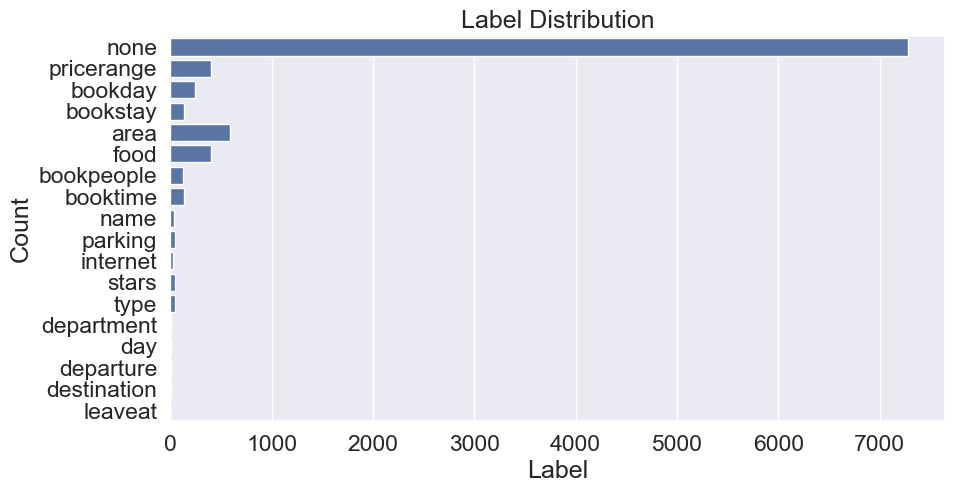

In [169]:
plot_label_distribution([label for sublist in y_train for label in sublist])   

There is a class imbalance of 'none' labels.

In [184]:
import random

def undersample_none_label(x_data, y_data, random_state=None):
    """
    Undersamples the 'none' label in a multi-label dataset.
    
    :param x_data: Feature set, list of lists or similar.
    :param y_data: Label set, list of lists or lists of sets of labels.
    :param random_state: Integer seed for reproducibility (default: None).
    :return: Tuple of undersampled (x_data, y_data).
    """
    if random_state is not None:
        random.seed(random_state)

    # Convert labels to a set for easier manipulation
    y_data_sets = [set(labels) for labels in y_data]

    # Separate 'none' instances
    none_indices = [i for i, labels in enumerate(y_data_sets) if labels == {'none'}]
    other_indices = [i for i, labels in enumerate(y_data_sets) if labels != {'none'}]

    # Randomly undersample 'none' instances
    random.shuffle(none_indices)
    none_indices = none_indices[:len(other_indices)]

    # Combine back the indices
    undersampled_indices = none_indices + other_indices

    # Subset the original x_data and y_data
    x_data_undersampled = [x_data[i] for i in undersampled_indices]
    y_data_undersampled = [y_data[i] for i in undersampled_indices]

    return x_data_undersampled, y_data_undersampled

x_train, y_train = undersample_none_label(x_train, y_train, random_state=42)
x_val, y_val = undersample_none_label(x_val, y_val, random_state=42)
x_test, y_test = undersample_none_label(x_test, y_test, random_state=42)


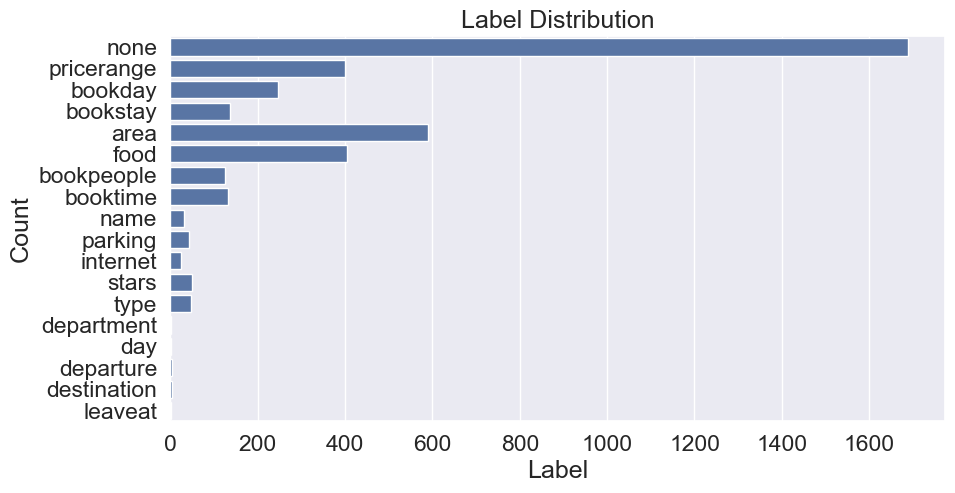

In [185]:
plot_label_distribution([label for sublist in y_train for label in sublist])

In [186]:
print("Number of training examples: ", len(x_train))

Number of training examples:  3380


In [187]:
from sklearn.preprocessing import MultiLabelBinarizer

# convert the labels to binary

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)


In [188]:
print("Binary labels: ", y_train[0])

Binary labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [189]:
print("Number of classes: ", len(mlb.classes_))

Number of classes:  18


In [191]:
print("Input example: ", x_train[2])    

Input example:  ['Restaurant-Request', 'address:?', 'restaurant-address:35 Sanit Andrews street city centre', 'restaurant-area:Centre', 'restaurant-availability:yes', 'restaurant-name:The Varisty restaurant', 'restaurant-phone:01223 356060']


In [225]:
from transformers import BertTokenizer
import torch

def prepare_data_for_bert(x_data, y_data, max_length=512):
    """
    Prepare the data for BERT.
    """
    
    input_ids = []
    attention_masks = []
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    for x in x_data:
        x_joined = ' '.join(x)
        
        # Optional: Check the length after joining
        if len(x_joined) > max_length:
            print("Warning: Truncating input with length %d to max_length %d." % (len(x_joined), max_length))
        
        x_encoded = tokenizer.encode_plus(
            x_joined,
            max_length=max_length,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(x_encoded['input_ids'])
        attention_masks.append(x_encoded['attention_mask'])
        
    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    y_data_tensor = torch.tensor(y_data)
    
    return input_ids, attention_masks, y_data_tensor


In [227]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_masks[idx], self.labels[idx]


In [228]:
train_dataset = CustomDataset(*prepare_data_for_bert(x_train, y_train))
val_dataset = CustomDataset(*prepare_data_for_bert(x_val, y_val))
test_dataset = CustomDataset(*prepare_data_for_bert(x_test, y_test))

In [240]:
# set the batch size
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [241]:
from transformers import BertModel
import torch.nn as nn

class BertForMultiLabelClassification(nn.Module):
    def __init__(self, num_labels):
        super(BertForMultiLabelClassification, self).__init__()
        self.num_labels = num_labels

        # Load the pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add a linear layer for classification; the output dimension is num_labels
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get the output from BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # The pooled_output is a summary of the content, according to BERT
        pooled_output = outputs.pooler_output

        # Apply the classification layer to the pooled output
        logits = self.classifier(pooled_output)

        return logits

In [242]:
num_labels = len(mlb.classes_)

model = BertForMultiLabelClassification(num_labels)

In [243]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [245]:
from sklearn.metrics import classification_report
import numpy as np

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device):
    early_stopping = EarlyStopping(patience=2, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(b_input_ids, b_attention_mask)
            loss = criterion(outputs, b_labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

                outputs = model(b_input_ids, b_attention_mask)
                loss = criterion(outputs, b_labels.float())
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss:.4f}")

        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

In [246]:
def evaluate_model(model, test_dataloader, device, threshold=0.5, path_to_model=None):
    if path_to_model:
        model.load_state_dict(torch.load(path_to_model))
    model.eval()

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

            outputs = model(b_input_ids, b_attention_mask)
            preds = torch.sigmoid(outputs).cpu().numpy()
            labels = b_labels.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

    # Flatten the outputs and labels lists
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Apply threshold to convert probabilities to binary predictions
    all_preds_binary = (all_preds > threshold).astype(int)

    return all_preds_binary, all_labels

In [247]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=10, device=device)
y_pred, y_true = evaluate_model(model, test_dataloader, device)

label_names = mlb.classes_.tolist()

print(classification_report(y_true, y_pred, target_names=label_names))


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 3.22 GiB is allocated by PyTorch, and 56.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF